In [1]:
import numpy as np
import cvxpy as cp
import scipy as sp
from datetime import datetime
import imageio
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import Image

## Simulation Parameters

In [2]:
dt = 0.04  # timestep
t = 3  # duration
m = 1  # mass
q0 = np.array([0, 0, 1])  # init pos
v0 = np.array([1, 2, 2])  # init vel
# force = np.array([0, 30])  # init force
g = 9.8  # gravitational acceleration
# mu = 0.05  # coefficient of friction of the plane
n = np.array([0, 0, 1])  # phi(q) = n @ q

## Simulation Backend

In [3]:
class SimSystem:
    def __init__(self, q0, v0):
        self.q = q0
        self.v = v0
    
    def step_q(self, update=True):
        """ Find next q according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
        
    def step_v(self, update=True):
        """ Find next v according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
    
    def plot(self, q=None):
        """
        Generate a plot for current config (or for Q if specified)
        """
        raise NotImplementedError()
    
    @property
    def dim(self):
        return self.q.shape[0]
        

In [4]:
class Block2DImpact(SimSystem):
    def __init__(self, pos, vel, mass,
                 dt=0.1, solver='ECOS'):
        super().__init__(pos, vel)
        self.m = mass
        self.dt = dt
        self.solver = solver
    
    def step_q(self, update=True):
        q_new = self.q + self.dt * self.v
        if update:
            self.q = q_new
        return q_new
    
    def step_v(self, return_dual=False, update=True):
        v = cp.Variable(self.dim)
        constraints = [dt * (n @ v) >= -n @ self.q]
        prob = cp.Problem(cp.Minimize(0.5 * self.m * cp.norm(v, 2)**2 - self.m * v @ self.v + self.dt * g * self.m * n @ v), constraints)
        prob.solve(solver=self.solver)
        v_new = v.value
        if update:
            self.v = v_new
        return v_new if not return_dual else v_new, constraints[0].dual_value
    
    def plot(self, q=None):
        if q is None:
            q = self.q
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        plt.xlim(-8, 8)
        plt.ylim(-8, 8)
        plt.plot(q[0], q[1], 'ro')
        canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return img

## Run Simulation

In [5]:
def sim(system, timesteps=10, return_dual=False):
    """
    :param system: (SimSystem) initialized obj representing system,
                    including functions to update q and v
    :param timesteps: (int) number of timesteps to simulate for
    """
    qs, vs = [system.q.copy()], [system.v.copy()]
    t = 0
    if return_dual:
        duals = []
    while t < timesteps:
        qs.append(system.step_q().copy())
        if return_dual:
            v, lamb = system.step_v(return_dual=return_dual)
            duals.append(lamb)
        else:
            v = system.step_v(return_dual=return_dual)
        vs.append(v)
        t += system.dt
    return np.stack(qs) if not return_dual else np.stack(qs), np.array(duals)

In [6]:
system = Block2DImpact(q0, v0, m, dt, solver='ECOS')
qs, duals = sim(system, timesteps=t, return_dual=True)

In [7]:
qs, duals

(array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [4.00000000e-02, 8.00000000e-02, 1.08000000e+00],
        [8.00015787e-02, 1.60003157e-01, 1.14431521e+00],
        [1.20003631e-01, 2.40007263e-01, 1.19295172e+00],
        [1.60005978e-01, 3.20011957e-01, 1.22590785e+00],
        [2.00008477e-01, 4.00016954e-01, 1.24318445e+00],
        [2.40010240e-01, 4.80020479e-01, 1.24478119e+00],
        [2.80012011e-01, 5.60024023e-01, 1.23069810e+00],
        [3.20014098e-01, 6.40028195e-01, 1.20093493e+00],
        [3.60016689e-01, 7.20033377e-01, 1.15549183e+00],
        [4.00019250e-01, 8.00038500e-01, 1.09436818e+00],
        [4.40022163e-01, 8.80044325e-01, 1.01756426e+00],
        [4.80025082e-01, 9.60050164e-01, 9.25080306e-01],
        [5.20027979e-01, 1.04005596e+00, 8.16916239e-01],
        [5.60030836e-01, 1.12006167e+00, 6.93072032e-01],
        [6.00033756e-01, 1.20006751e+00, 5.53548141e-01],
        [6.40036911e-01, 1.28007382e+00, 3.98344231e-01],
        [6.800

## Plot

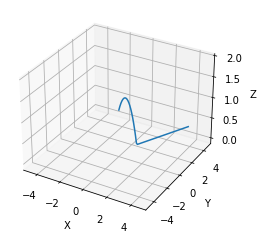

In [8]:
Writer = animation.writers['pillow']
writer = Writer(fps=int(1/dt), bitrate=600)

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

fig = plt.figure()
ax = fig.gca(projection='3d')
line, = ax.plot(qs[:1, 0], qs[:1, 1], qs[:1, 2])
ax.set_xlim3d([-5, 5])
ax.set_xlabel('X')
ax.set_ylim3d([-5, 5])
ax.set_ylabel('Y')
ax.set_zlim3d([-0.1, 2])
ax.set_zlabel('Z')
ani = animation.FuncAnimation(fig, update, int(t / dt), fargs=(qs.T, line), interval=dt, blit=False)
time = datetime.now().strftime('%m%d%y_%H%M%S')
filename = f'gifs/impact/sim2d_impact_{time}.gif'
ani.save(filename, writer=writer)

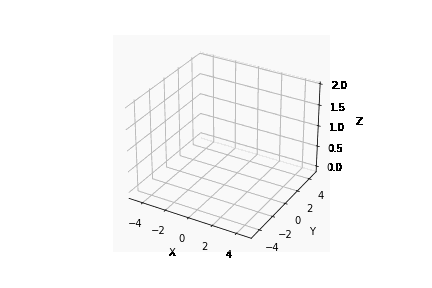

In [9]:
Image(filename=filename)